In [249]:
import numpy as np
import torch
from itertools import product
from scipy import stats
from functools import partial

In [319]:
# Linear regression
num_samples = 300       # per group (total = num_samples * num_groups)
num_features = 700
num_groups = 3

np.random.seed(42)
noise_level = 0.1
true_beta = np.random.randn( num_features, 1 ) # does not include the identifier weight.

In [335]:
def fully_structured_covariance(d):
    return np.diag( np.random.uniform(0.3, 4, size = d) ** 2 )

def identity_covariance(d):
    return np.identity( d )

def partially_structured_covariace(d):
    U = np.random.randn(d,d) / np.sqrt(d)
    return np.matmul(U, U.T)

def unstructured_covariace(d):
    U = np.random.randn(d,d) / np.sqrt(d)
    return np.matmul(U, np.matmul(fully_structured_covariance(d), U.T))

class Group:

    ID = 0

    def __init__(self, covariance_generator = lambda: identity_covariance(num_features) ):

        self.id = Group.ID 
        Group.ID += 1

        self.cov = covariance_generator()
        self.x_dist = stats.multivariate_normal( cov = self.cov )

        self.x = None
        self.y = None
    
    # Generates X (input vars) 
    def _generate_x(self, n_samples, ID = False , **kwargs):
        x = self.x_dist.rvs(size= n_samples, **kwargs)
        if ID:
            identifier = np.repeat( self.ID , repeats=n_samples)
            x = np.column_stack( (identifier, x))
        return x

    
    @property
    def data(self):
        return self.x, self.y
    
    @data.setter
    def data(self, value):
        x, y = value # unpack
        self.x = torch.tensor(x, dtype = torch.float32, requires_grad=False)
        self.y = torch.tensor(y, dtype = torch.float32, requires_grad=False)
    

class Groups:

    WEIGHT_HANDLER = stats.beta(1,1).rvs

    def __init__(self, num_groups, cov_generator = identity_covariance):

        Group.ID = 0
        self.groups = [ Group(cov_generator) for _ in range(num_groups) ]

        weights = self.WEIGHT_HANDLER(size = num_groups)
        weights /= weights.sum()
        self.weights = weights

        self.x , self.y = None, None
    
    
    def __iter__(self):
        return self.groups.__iter__()
    
    def __getitem__(self, index):
        return self.groups[index]

    def generate(self, n_samples, beta = true_beta):

        for group in self.groups:
            # Determine number of samples for this group
            n_group = self._get_nsample(n_samples, group)

            # Create the data for that specific group
            x = group._generate_x(n_group)
            y = np.dot(x, beta) + noise_level * np.random.randn(n_group, 1)
            
            group.data = [x, y]
    
    def _get_nsample(self, n, group):
        weights = self.weights
        weights = (weights * n).astype(int)
        weights[-1] = n - weights[:-1].sum()
        return int(weights[group.id])

    
    @property
    def data(self):
        if self.x is None:
            self.x = torch.cat( [ group.x for group in self.groups ], dim = 0 )
            self.y = torch.cat( [ group.y for group in self.groups ], dim = 0 )
        return self.x, self.y

    @data.setter
    def data(self,value):
        raise AttributeError("Can't assign data to this object.")
    
    

In [336]:

class LinearModel(torch.nn.Module):

    def __init__(self, input_dimension, **kwargs) -> None:
        super(LinearModel, self).__init__()
        # Initialize at zero. 
        self.linear = torch.nn.Linear( input_dimension, 1, bias = False, **kwargs )
        self._initialize(0.0)
    
    @torch.no_grad()
    def _initialize(self, value):
        self.linear.weight.fill_(value)
        if self.linear.weight.grad is not None:
            self.linear.weight.grad.detach_()
            self.linear.weight.grad.zero_()
    
    # forward passes should NOT come from calling this directly!
    # i.e. model(x) instead of model.forward(x)
    def forward(self, x):
        out = self.linear(x)
        return out
    
    # by default, MSELoss divides by n, the size of sample
    def risk(self, x, y):
        loss = torch.nn.MSELoss()
        mse = loss( self(x) , y )
        return mse
    
# training loop (gradient descent on the balanaced risk: lmbd * std + dro)
def optimize_GD(model, X, Y, groups, trade_regularization = 0.1, max_iter = 5000, lr = 1e-3, weight_decay = 0.0, verbose=False):
    if trade_regularization > 1:
        lmbd_adv = torch.tensor([1.0], requires_grad=False)
        lmbd_std = torch.tensor([1 / trade_regularization], requires_grad=False)
    else:
        lmbd_adv = torch.tensor([trade_regularization], requires_grad=False)
        lmbd_std = torch.tensor([1.0], requires_grad=False)

    optimizer = torch.optim.SGD( params = model.parameters(), lr = lr, weight_decay = weight_decay )

    flag = True         # for convergence criterion (objective low enough)
    iteration = 0
    while flag and iteration < max_iter:
        optimizer.zero_grad()

        standard_risk = model.risk( X, Y )
        adversarial_risk = torch.max( torch.stack( [ model.risk(group.x, group.y) for group in groups ] ) )
        objective =  standard_risk * lmbd_std + adversarial_risk * lmbd_adv

        objective.backward()
        optimizer.step()

        if iteration % 100 == 0 and verbose:
            print(f" Objective loss is {objective.item():.4f} = {lmbd_std.item():.2f} * { standard_risk.item():.4f} + {lmbd_adv.item():.2f} * {adversarial_risk.item():.4f}")
        iteration += 1

        # Check convergence
        if objective.item() < 1e-4:
            flag = False
    
    if iteration == max_iter:
        print("Maximum iteration reached.")

In [342]:
# Create the data
cov_generator = lambda: unstructured_covariace(num_features)
groups = Groups(num_groups, cov_generator)

# TODO: by this data generating process, we have equal number of groups in the
# training data, all disjoint. should we change this up (vary # of samples/gp)?
groups.generate(num_samples, beta= true_beta)

X , Y = groups.data

# Solve the weighted regression problem using vanilla GD
max_iter = float('inf')

model = LinearModel(num_features)
optimize_GD(model, X, Y, groups, trade_regularization = 1e2, lr=1e-3, max_iter= max_iter, verbose=True)

 Objective loss is 4546.8491 = 0.01 * 3920.4954 + 1.00 * 4507.6440
 Objective loss is 86.1022 = 0.01 * 83.2433 + 1.00 * 85.2698
 Objective loss is 21.0247 = 0.01 * 19.9931 + 1.00 * 20.8247
 Objective loss is 7.2654 = 0.01 * 7.0683 + 1.00 * 7.1947
 Objective loss is 3.1588 = 0.01 * 2.9507 + 1.00 * 3.1293
 Objective loss is 1.4398 = 0.01 * 1.3710 + 1.00 * 1.4261
 Objective loss is 0.7005 = 0.01 * 0.6860 + 1.00 * 0.6936
 Objective loss is 0.3794 = 0.01 * 0.3550 + 1.00 * 0.3758
 Objective loss is 0.2013 = 0.01 * 0.1910 + 1.00 * 0.1994
 Objective loss is 0.1079 = 0.01 * 0.1043 + 1.00 * 0.1069
 Objective loss is 0.0624 = 0.01 * 0.0585 + 1.00 * 0.0618
 Objective loss is 0.0345 = 0.01 * 0.0328 + 1.00 * 0.0342
 Objective loss is 0.0201 = 0.01 * 0.0189 + 1.00 * 0.0199
 Objective loss is 0.0113 = 0.01 * 0.0108 + 1.00 * 0.0112
 Objective loss is 0.0066 = 0.01 * 0.0063 + 1.00 * 0.0065
 Objective loss is 0.0038 = 0.01 * 0.0037 + 1.00 * 0.0038
 Objective loss is 0.0022 = 0.01 * 0.0022 + 1.00 * 0.0022

In [343]:
# OLS
ols_beta = torch.linalg.lstsq( X, Y ).solution

# Subgroups- OLS
subgroup_beta = [ torch.linalg.lstsq( group.x, group.y ).solution for group in groups ]

In [344]:
import pandas as pd
import matplotlib.pyplot as plt

betas = np.hstack( [true_beta, model.linear.weight.data.numpy().T, ols_beta.data.numpy()] + [beta.data.numpy() for beta in subgroup_beta ] )
betas = pd.DataFrame( betas, columns=["true_beta", "model", "OLS"] + [f"Group {i} OLS" for i in range(num_groups)] )

In [341]:
betas.corr()

,true_beta,model,OLS,Group 0 OLS,Group 1 OLS,Group 2 OLS
true_beta,1.000000,0.699505,0.699505,0.369453,0.355829,0.458924
model,0.699505,1.000000,1.000000,0.528292,0.509027,0.656233
OLS,0.699505,1.000000,1.000000,0.528272,0.508986,0.656194
Group 0 OLS,0.369453,0.528292,0.528272,1.000000,0.088858,0.118470
Group 1 OLS,0.355829,0.509027,0.508986,0.088858,1.000000,0.165822
Group 2 OLS,0.458924,0.656233,0.656194,0.118470,0.165822,1.000000


## Experiment 1: Varying $\lambda$ Tradeoff Parameter
Our notion of tradeoff risk between DRO and standard risk is controlled by the parameter $\lambda$. Fully writing out the
tradeoff objective, we have:
$$
\mathcal{R}_{\mathrm{trade}}(\beta; \lambda) := \lambda \mathcal{R}_{\mathrm{group}}(\beta) +  \mathcal{R}_{\mathrm{std}}(\beta)
= \lambda \max_{g \in \mathcal{G}} \mathbb{E}[(X^\top \beta - Y)^2 | X \in g ] +  \mathbb{E}_{X \sim \mathbb{P}_X}\left[ \mathbb{E} \left[ (X^\top \beta - Y)^2 \mid X \right] \right],
$$
where $\mathbb{P}_g$ is the group distribution for group $g \in \mathcal{G}$. The $\lambda$ parameter controls how much we tradeoff for standard risk in our objective. $\lambda = 0$ means we are solely optimizing for group DRO. We vary the value of $\lambda$ and see if this has any effect on the resulting $\hat{\beta}$ that our model produces by minimizing $\hat{\mathcal{R}}_{\mathrm{trade}}$


In [188]:
import matplotlib.pyplot as plt

max_iter = 5000
lambdas = np.logspace(-5, 3, 20)
model_betas = list()

for lmbd in lambdas:
    # train tradeoff model
    model = LinearModel(num_features)
    optimize_GD(model, X, Y, groups, trade_regularization = lmbd, lr = 1e-3,max_iter= max_iter, verbose=True)
    model_betas.append(model.linear.weight.data.numpy().T)

 Objective loss is 4193.0852 = 1.00 * 4193.0342 + 0.00 * 5103.8906
 Objective loss is 77.0369 = 1.00 * 77.0361 + 0.00 * 79.5078
 Objective loss is 15.7893 = 1.00 * 15.7891 + 0.00 * 17.8931
 Objective loss is 4.6580 = 1.00 * 4.6580 + 0.00 * 5.3538
 Objective loss is 1.6214 = 1.00 * 1.6213 + 0.00 * 1.8299
 Objective loss is 0.6249 = 1.00 * 0.6249 + 0.00 * 0.6853
 Objective loss is 0.2582 = 1.00 * 0.2582 + 0.00 * 0.2747
 Objective loss is 0.1122 = 1.00 * 0.1122 + 0.00 * 0.1212
 Objective loss is 0.0505 = 1.00 * 0.0505 + 0.00 * 0.0555
 Objective loss is 0.0233 = 1.00 * 0.0233 + 0.00 * 0.0261
 Objective loss is 0.0110 = 1.00 * 0.0110 + 0.00 * 0.0125
 Objective loss is 0.0053 = 1.00 * 0.0053 + 0.00 * 0.0061
 Objective loss is 0.0026 = 1.00 * 0.0026 + 0.00 * 0.0030
 Objective loss is 0.0012 = 1.00 * 0.0012 + 0.00 * 0.0015
 Objective loss is 0.0006 = 1.00 * 0.0006 + 0.00 * 0.0007
 Objective loss is 0.0003 = 1.00 * 0.0003 + 0.00 * 0.0004
 Objective loss is 0.0002 = 1.00 * 0.0002 + 0.00 * 0.0002

Text(0, 0.5, '$\\| \\beta_{\\mathrm{trade}} - \\beta_{\\mathrm{OLS}} \\|_2$')

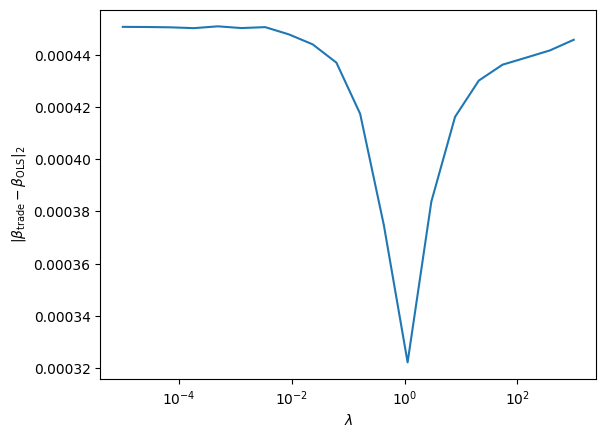

In [189]:
# Plot difference between model's betas and OLS beta
# Is this actually a significant difference?
beta_l2 = [np.linalg.norm(model_beta - ols_beta.numpy()) / np.linalg.norm(ols_beta.numpy()) for model_beta in model_betas]
plt.plot(lambdas, beta_l2)
plt.xscale('log')
plt.xlabel(r'$\lambda$')
plt.ylabel(r'$\| \beta_{\mathrm{trade}} - \beta_{\mathrm{OLS}} \|_2$')

## Experiment 2: Adding Explicit Regularizer and Varying $\lambda$ Tradeoff Parameter
Now, we add an explicit $\ell_2$ regularization to the objective, controlled by $\eta > 0.$ This gives us the objective:
$$
\mathcal{R}_{\mathrm{trade}}(\beta; \lambda) + \eta \|\beta\|_2
= \lambda \max_{g \in \mathcal{G}} \mathbb{E}_{(X, Y) \sim \mathbb{P}_g}[(X^\top \beta - Y)^2] + \mathbb{E}_{X \sim \mathbb{P}_X}\left[ \mathbb{E} \left[ (X^\top \beta - Y)^2 \mid X \right] \right] + \eta\|\beta\|_2.
$$
Again, we first look at the effect that varying $\lambda$ has on this objective.

In [95]:
import matplotlib.pyplot as plt

max_iter = 2000
lambdas = torch.tensor(np.linspace(0, 10.0), requires_grad=False)
ols_beta = torch.linalg.lstsq( X, Y ).solution  # regular OLS solution (TODO: regularize this)
subgroup_betas = [ torch.linalg.lstsq( group.x, group.y ).solution for group in groups ] # OLS for each group
model_betas = list()

# Fix beta regularizer to 0.1, vary lambdas
for lmbd in lambdas:
    # train tradeoff model
    model = LinearModel(num_features)
    optimize_GD(model, trade_regularization = lmbd, beta_regularization=0.1, max_iter= max_iter)
    model_betas.append(model.linear.weight.data.numpy().T)

 Objective loss is 4394.8877  = 0.00 * 3851.1809 + 4394.8877
 Objective loss is 101.1026  = 0.00 * 94.1922 + 99.6609
 Objective loss is 24.1462  = 0.00 * 21.3383 + 22.5286
 Objective loss is 9.4619  = 0.00 * 7.3925 + 7.7818
 Objective loss is 4.9382  = 0.00 * 3.0047 + 3.2281
 Objective loss is 3.1003  = 0.00 * 1.3300 + 1.3731
 Objective loss is 2.3647  = 0.00 * 0.6172 + 0.6273
 Objective loss is 2.0625  = 0.00 * 0.2982 + 0.3186
 Objective loss is 1.8994  = 0.00 * 0.1487 + 0.1514
 Objective loss is 1.8285  = 0.00 * 0.0758 + 0.0778
 Objective loss is 1.7935  = 0.00 * 0.0396 + 0.0409
 Objective loss is 1.7758  = 0.00 * 0.0211 + 0.0220
 Objective loss is 1.7670  = 0.00 * 0.0116 + 0.0124
 Objective loss is 1.7621  = 0.00 * 0.0065 + 0.0069
 Objective loss is 1.7598  = 0.00 * 0.0038 + 0.0042
 Objective loss is 1.7583  = 0.00 * 0.0024 + 0.0025
 Objective loss is 1.7577  = 0.00 * 0.0015 + 0.0016
 Objective loss is 1.7574  = 0.00 * 0.0011 + 0.0011
 Objective loss is 1.7572  = 0.00 * 0.0008 + 0.0

In [ ]:
# TODO: do standard OLS with regularization to compare?

# TODO: Change the convergence criterion
# TODO: Change the objective to model selection.